接下来，我们将在一个大的数字范围内测试素数。这与估计 $\pi$ 是一个不同的问题，因为工作负载取决于您在数字范围中的位置，并且每个数字的检查都具有不可预测的复杂性。我们可以创建一个串行例程来检查素数，然后将一组可能的因子传递给每个进程进行检查。这个问题是令人尴尬的平行，这意味着没有需要共享的状态。

多处理模块使得控制工作负载变得容易，因此我们将研究如何调整工作队列以使用（和误用！）我们的计算资源，我们将探索一种简单的方法来稍微更有效地使用我们的资源。这意味着我们将研究负载平衡，以尝试有效地将不同复杂性的任务分配到固定的资源集。

我们将使用一种算法，该算法与本课程前面的算法略有不同（请参阅“理想化计算与Python虚拟机之比较”）；如果我们有一个偶数，它就会提前退出

用Python求素数:

In [1]:
import math
import time


def check_prime(n):
    if n % 2 == 0:
        return False
    for i in range(3, int(math.sqrt(n)) + 1, 2):
        if n % i == 0:
            return False
    return True


if __name__ == "__main__":
    primes = []
    t1 = time.time()
    #number_range = xrange(100000000, 100010000)  # A
    #number_range = xrange(100000000, 100100000)  # B
    number_range = range(100000000, 101000000)  # C
    #number_range = xrange(1000000000, 1000100000)  # D
    #number_range = xrange(100000000000, 100000100000)  # E

    for possible_prime in number_range:
        if check_prime(possible_prime):
            primes.append(possible_prime)

    print("Took:", time.time() - t1)
    print(len(primes), primes[:10], primes[-10:])

Took: 29.511687994003296
54208 [100000007, 100000037, 100000039, 100000049, 100000073, 100000081, 100000123, 100000127, 100000193, 100000213] [100999889, 100999897, 100999901, 100999903, 100999919, 100999939, 100999949, 100999979, 100999981, 100999993]


当用这种方法测试一个素数时，我们看到的工作量变化有多大？数字 9-9显示了当可能的素数n从10000增加到1000000时，检查素数的时间开销在增加。

大多数数字是非质的；它们是用一个点画的。有些可以便宜地检查，而另一些则需要检查许多因素。素数用x表示，形成较厚的深色带；他们是最昂贵的检查。检查一个数的时间成本随着n的增加而增加，因为检查的可能因素的范围随着n的平方根的增加而增加。素数序列是不可预测的，因此我们无法确定一系列数字的预期成本（我们可以估计它，但我们不能确定它的复杂性）。

对于该图，我们对每个n进行200次测试，并取最快的结果来消除结果中的抖动。如果我们只得到一个结果，我们会看到由其他进程的系统负载引起的时间上的巨大差异；通过多次阅读并保持最快速度，我们可以看到预期的最佳时机。

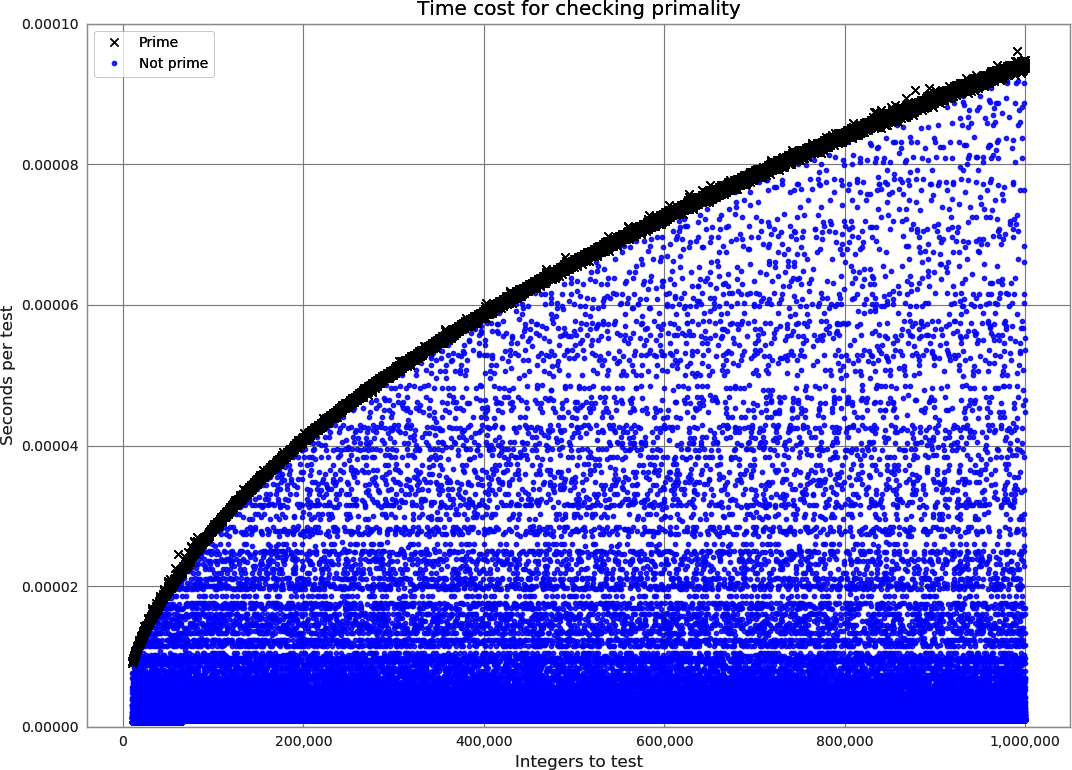

当n增加时检查素性所需的时间

当我们将工作分配给一个进程池时，我们可以指定有多少工作被传递给每个工作者。我们可以平均分配所有的工作，并以一次通过为目标，或者我们可以制作许多工作块，并在CPU空闲时将它们发送出去。这是使用chunksize参数控制的。较大的工作块意味着更少的通信开销，而较小的工作块意味着对资源分配方式的更多控制。

对于质数查找器，单个工件是一个由check\u质数检查的数字n。chunksize为10意味着每个进程处理10个整数的列表，一次处理一个列表。

在图中，我们可以看到改变chunksize的效果，从1（每个作业都是一个单独的工作）到64（每个作业都是一个由64个数字组成的列表）。虽然有许多微小的工作给了我们最大的灵活性，但它也带来了最大的通信开销。所有四个cpu都将得到有效利用，但由于每个作业和结果都通过这个单一通道，因此通信管道将成为瓶颈。如果我们将chunksize加倍为2，我们的任务得到解决的速度将加倍，因为我们在通信管道上的争用更少。我们可能天真地认为，通过增加chunksize，我们将继续改进执行时间。然而，正如你在图中看到的，我们将再次来到一个收益递减的点。

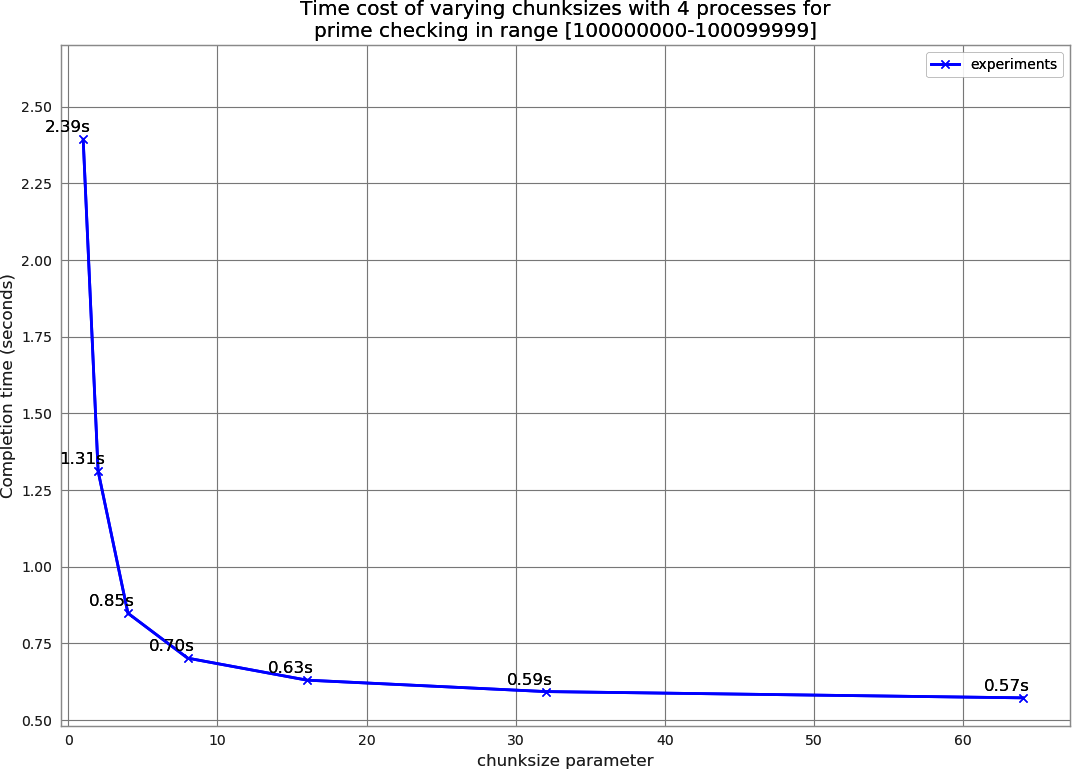

我们可以继续增加chunksize，直到我们开始看到行为的恶化。在图中，我们扩大了块大小的范围，使它们不仅很小，而且很大。在更大的范围内，显示的最差结果是1.08秒，我们要求chunksize为50000这意味着我们的100000个项目被分成两个工作块，在整个过程中留下两个cpu空闲。拥有10000个项目的chunksize，我们正在创建10个工作块；这意味着四个工作块将并行运行两次，然后是剩余的两个工作块。这使得两个cpu在第三轮工作中处于空闲状态，这是对资源的低效利用。

这种情况下的最佳解决方案是将作业总数除以CPU的数量。这是多处理中的默认行为，如图中的“默认”蓝点所示。

一般来说，违约行为是合理的；只有当你期望看到一个真正的收益时，才调整它，并且确定你的假设与默认行为相反。

与montecarlo-pi问题不同的是，我们的素数测试计算具有不同的复杂性有时一个作业很快退出（偶数最快被检测到），有时一个素数很大（这需要更长的时间来检查）。

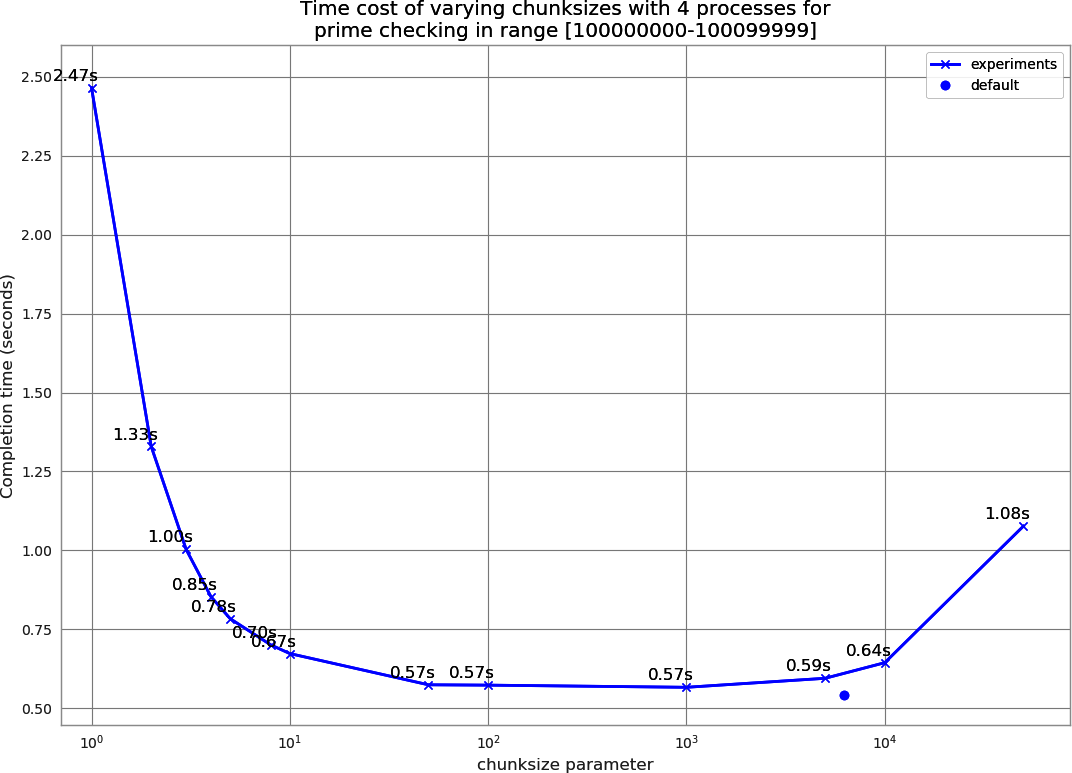

选择合理的chunksize值（续）

如果我们随机化我们的工作顺序会发生什么？对于这个问题，我们挤出了2%的性能增益，如图所示 9-12. 通过随机化，我们减少了序列中的最后一个作业比其他作业花费更长时间的可能性，只剩下一个CPU处于活动状态。

正如前面使用chunksize为10000的示例所示，工作负载与可用资源的数量不一致会导致效率低下。在这种情况下，我们创建了三轮工作：前两轮使用100%的资源，最后一轮仅使用50%。

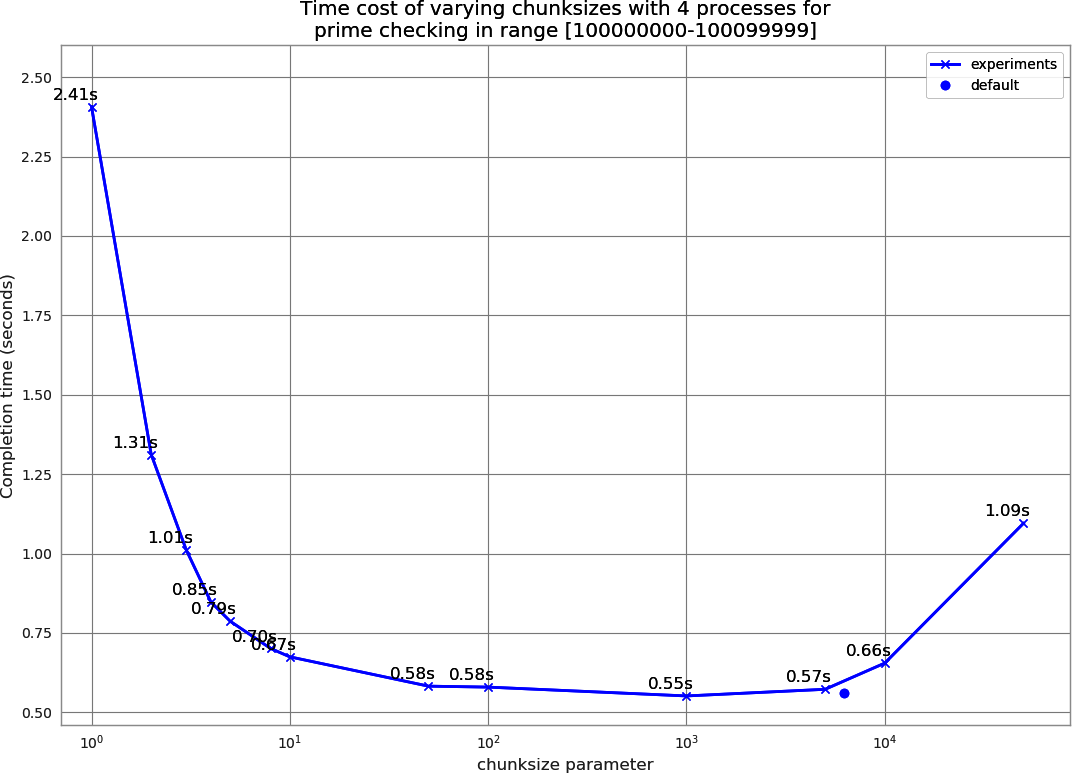

随机化作业顺序.

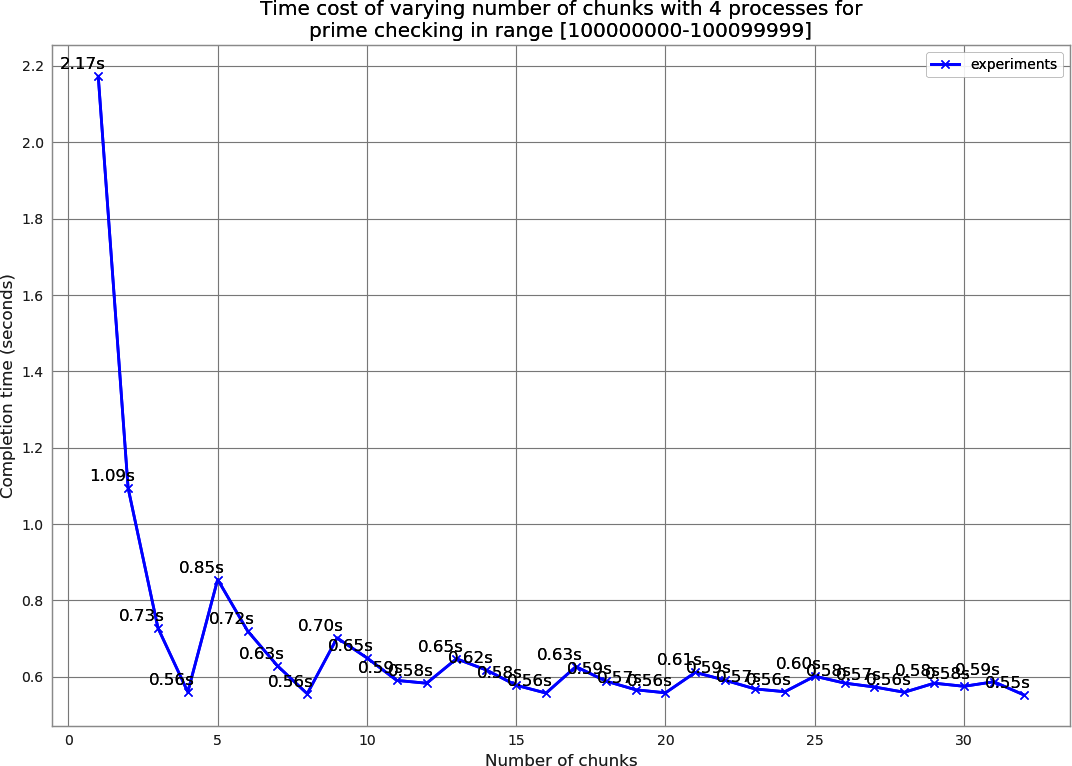

以下是一些有效利用多重处理解决尴尬的并行问题的策略：
- 把你的工作分成独立的工作单元。
- 如果您的工作人员花费的时间不同，请考虑将工作顺序随机化（另一个示例是处理可变大小的文件）。
- 对工作队列进行排序，使最慢的作业优先处理，可能是一种同样有用的策略。
- 使用默认的chunksize，除非您已经验证了调整它的原因。
- 将作业数与物理CPU数对齐(同样，默认的chunksize为您解决了这个问题，尽管它在默认情况下会使用任何超线程，这可能不会提供任何额外的增益。）

请注意，默认情况下，多处理将超线程视为附加CPU。这意味着在笔记本电脑上，它将分配8个进程，而实际上只有4个进程以100%的速度运行。额外的四个进程可能会占用宝贵的RAM，而几乎不会提供任何额外的速度增益。

有了一个池，我们可以在可用的cpu之间预先分割一大块预定义的工作。但是，如果我们有动态的工作负载，尤其是当我们的工作负载随着时间的推移而到达时，这就没有什么帮助了。对于这种工作负载，我们可能需要使用队列，这将在下一节中介绍。

## 工作队列

multiprocessing.Queue 对象为我们提供了非持久队列，可以在进程之间发送任何可pickle的Python对象。它们会带来开销，因为每个对象都必须经过pickle处理才能发送，然后在使用者中取消pickle（以及一些锁定操作）。在下面的例子中，我们将看到这个成本是不可忽略的。但是，如果您的工人正在处理更大的作业，那么通信开销可能是可以接受的。

处理队列相当容易。在本例中，我们将通过使用候选数字列表并将确认的素数发布回确定的素数队列来检查素数。我们将用一个、两个、四个和八个进程来运行它，并确认后三种方法都比只运行一个检查相同范围的进程要花费更长的时间。

队列使我们能够使用本机Python对象执行大量进程间通信。如果要传递具有大量状态的对象，这将非常有用。但是，由于队列缺乏持久性，您可能不希望将队列用于在出现故障时可能需要健壮性的作业（例如，如果断电或硬盘损坏）。

下面例子显示check_prime 函数。我们已经熟悉基本的素性测试了。我们在一个无限循环中运行，阻塞（等待工作可用）可能的possible_primes_queue.get()以使用队列中的项目。一次只能有一个进程获取一个项，因为队列对象负责同步访问。如果队列中没有工作，.get（）会阻塞，直到有任务可用。当找到素数时，它们将被放回definite_primes_queue，供父进程使用。

使用两个队列进行进程间通信（IPC）：

我们定义了两个标志：一个由父进程作为毒丸输入，以指示没有更多的工作可用，而另一个由工作进程输入，以确认它已看到毒丸并已自行关闭。第一个毒丸也被称为哨兵，因为它保证了处理循环的终止。

在处理工作队列和远程工作人员时，使用这样的标志来记录发送了毒丸，并检查是否在合理的时间窗口内从孩子们发送了响应，表明他们正在关闭。我们在这里不处理这个过程，但是添加一些计时是对代码的一个相当简单的添加。在调试期间可以记录或打印这些标志的接收。

在下面例中，队列对象是从管理器中创建的. 我们将使用熟悉的过程来构建一个流程对象列表，每个对象都包含一个分叉的流程。这两个队列作为参数发送，多处理处理处理它们的同步。启动新进程后，我们将一个作业列表交给可能的possible_primes_queue，并以每个进程一粒毒丸结束。这些工作将按先进先出的顺序被消耗掉，剩下的毒药将留到最后。在check_prime中，我们使用.get（），因为新进程必须等待工作出现在队列中。因为我们使用了标志，所以我们可以添加一些工作，处理结果，然后通过添加更多工作进行迭代，并通过稍后添加毒药来发出工人生命结束的信号。

为IPC构建两个队列：

为了使用结果，我们在示例中启动另一个无限循环，在 definite_primes_queue 上使用blocking.get（）。如果找到finished processing标志，我们将统计发出退出信号的进程数。如果没有，我们有一个新的素数，我们把它添加到素数列表中。当所有进程都发出退出信号时，我们就退出了无限循环。

对IPC使用两个队列：

由于pickling和同步，使用队列会有相当大的开销。如下图所示 ，使用无队列的单进程解决方案比使用两个或多个进程快得多。在这种情况下，原因是因为我们的工作量很轻，通信成本占了整个任务的时间。对于队列，两个进程完成本例的速度比一个进程快一些，而四个和八个进程都慢一些。

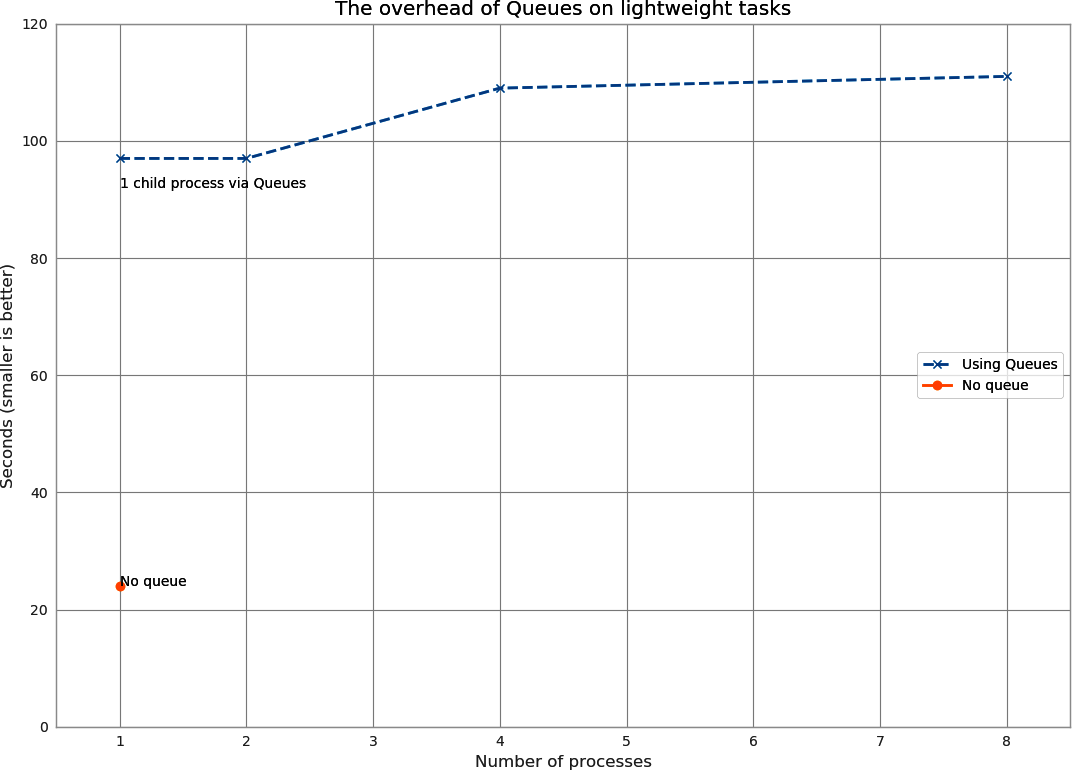

使用队列对象的成本。

如果任务的完成时间很长（至少相当于一秒钟的一小部分），而通信量很小，那么队列方法可能是正确的答案。您必须验证通信成本是否使这种方法足够有用。

您可能想知道，如果删除作业队列中多余的一半（所有偶数在 check_prime 中很快就会被拒绝），会发生什么情况。在每种情况下，将输入队列的大小减半将使我们的执行时间减半，但这仍然不能打败单进程非队列示例！这有助于说明，通信成本是这个问题的主导因素。

## 向队列异步添加作业

异步作业反馈函数：

现在，举个例子，我们的主线程将使用可能的素数队列设置线程，然后在发布任何工作之前进入结果收集阶段。异步作业馈送器可以消耗来自外部源（例如，来自数据库或I/O绑定通信）的工作，而主线程处理每个处理结果。这意味着不需要预先创建输入序列和输出序列；它们都可以在飞行中处理。

使用线程设置异步作业馈送器：

如果您想要健壮的异步系统，几乎可以肯定的是，您应该考虑使用asyncio或像tornado这样的外部库。有关这些方法的完整讨论，请参阅第章 8我们在这里看到的示例将让您开始学习，但实际上，它们对于非常简单的系统和教育比对于生产系统更有用。

请注意，异步系统需要特殊程度的耐心，在调试过程中，最终会导致头发脱落。我们建议如下：
- 运用“简单，愚蠢”的原则
- 尽可能避免异步自包含系统（如我们的示例），因为它们将变得越来越复杂，并且很快变得难以维护
- 使用成熟的库，比如gevent（在上一章中描述过），这些库为您提供了处理某些问题集的经过尝试和测试的方法

此外，我们强烈建议使用外部队列系统，使您能够从外部了解队列的状态（例如，NSQ，在“NSQ for Robust Production Clustering”中讨论）；ZeroMQ公司；或芹菜）。这需要更多的思考，但可能会节省您的时间，因为提高了调试效率和生产系统的更好的系统可见性。

# 利用进程间通信验证素数

素数是除了自身和1之外没有其他因子的数。很显然，最常见的因子是2（每个偶数不能是素数）。之后，低素数（如3、5、7）成为较大非素数（如9、15和21）的公因数。

假设我们得到了一个大数，并被要求验证它是否是素数。我们可能会有一个很大的搜索空间。数字 9-15显示了10000000以下非Prime的每个因子的频率。低因素比高因素更容易发生，但没有可预测的模式。

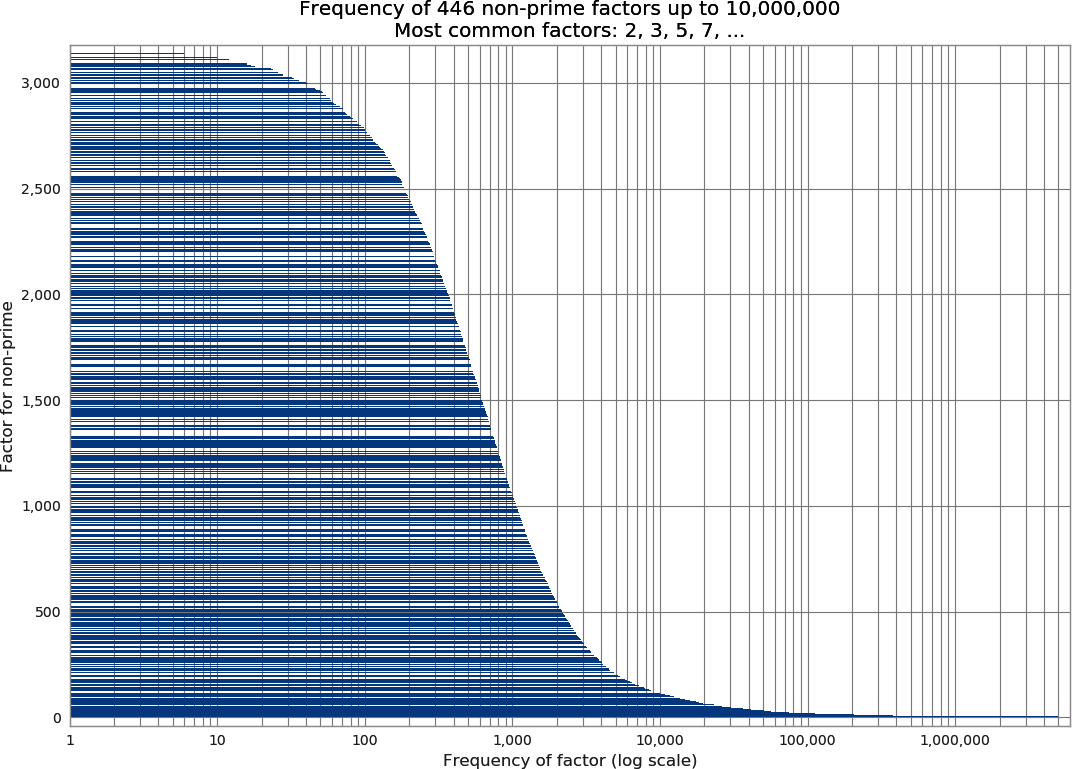

非Prime因素的频率

让我们定义一个新的问题，假设我们有一个小的数字集，我们的任务是有效地利用我们的CPU资源，找出每个数字是否是素数，一次一个数字。可能我们只有一个大的数字要测试。用一个CPU来做检查已经没有意义了；我们希望跨多个CPU协调工作。
在本节中，我们将看一些较大的数字，一个是15位数，四个是18位数：

- Small nonprime: 112,272,535,095,295
- Large nonprime 1: 100,109,100,129,100,369
- Large nonprime 2: 100,109,100,129,101,027
- Prime 1: 100,109,100,129,100,151
- Prime 2: 100,109,100,129,162,907

通过使用一个较小的非素数和一些较大的非素数，我们可以验证我们选择的过程不仅在检查素数时更快，而且在检查非素数时也不会变慢。我们将假设我们不知道给出的数字的大小或类型，所以我们希望所有用例都能得到尽可能快的结果。

通过使用一个较小的非素数和一些较大的非素数，我们可以验证我们选择的过程不仅在检查素数时更快，而且在检查非素数时也不会变慢。我们将假设我们不知道给出的数字的大小或类型，所以我们希望所有用例都能得到尽可能快的结果。

合作是有代价的，同步数据和检查共享数据的代价可能相当高。我们将研究几种方法，这些方法可以以不同的方式用于任务协调。

请注意，这里我们不讨论有点特殊化的消息传递接口（MPI）；我们正在研究电池包括模块和Redis（这是非常常见的）。如果你想使用MPI，我们假设你已经知道你在做什么。MPI4PY项目将是一个很好的起点。如果您想控制多个进程协作时的延迟，无论您有一台或多台机器，这都是一种理想的技术。

对于下面的运行，每个测试执行20次，并用最短时间显示该方法可能的最快速度。在这些示例中，我们使用各种技术来共享一个标志（通常为1字节）。我们可以使用一个像锁这样的基本对象，但这样我们就只能共享1位状态。我们选择向您展示如何共享一个基本类型，这样就可以实现更具表现力的状态共享（尽管本例不需要更具表现力的状态）。

我们必须强调的是，共享状态往往会使事情变得复杂，你很容易陷入另一种拉毛状态。要小心，尽量使事情尽可能简单。在这种情况下，效率较低的资源利用率可能会被开发人员花在其他挑战上的时间所压倒。

首先我们将讨论结果，然后我们将研究代码。

下图展示了第一种尝试使用进程间通信来更快地测试素性的方法。基准是串行版本，不使用任何进程间通信；每一次加速代码的尝试都必须至少比这更快。

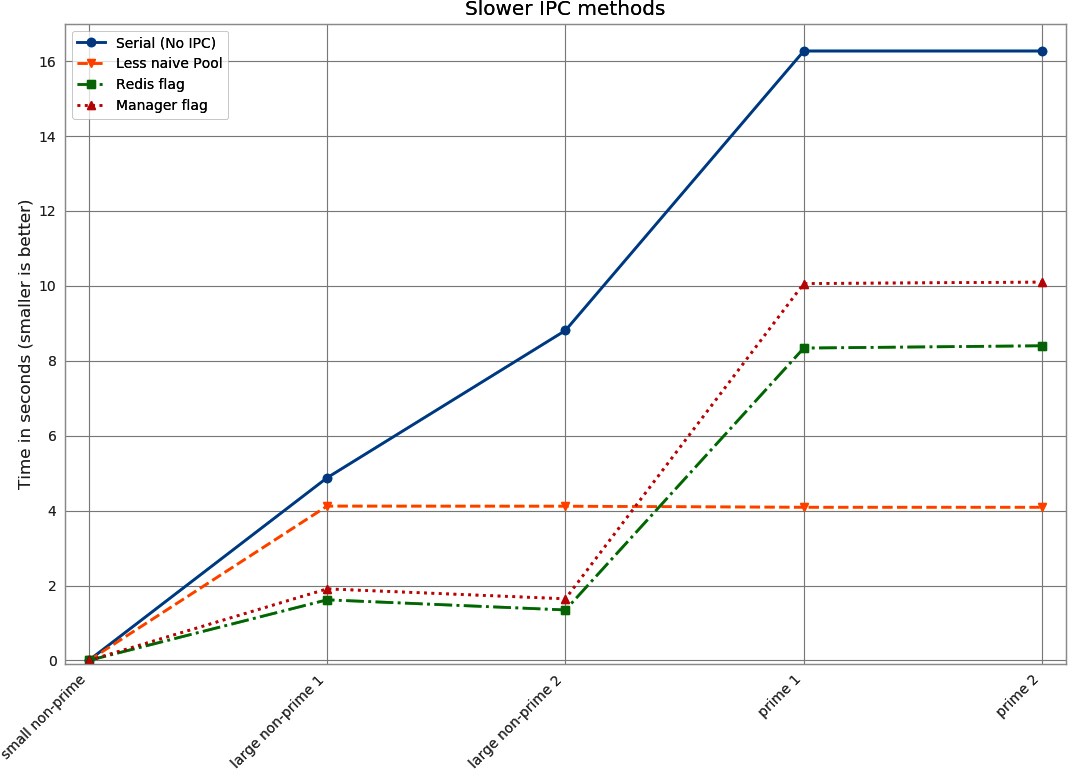

不那么幼稚的Pool版本有一个可预测的（而且很好的）速度。这足以让人难以击败。在寻找高速解决方案的过程中，不要忽视显而易见的问题，有时，一个愚蠢而足够好的解决方案就是你所需要的。

对于不太简单的池解决方案，方法是取我们的被测数字，在可用的CPU中平均划分其可能的因子范围，然后将计算结果推送到每个CPU。如果任何CPU发现一个因素，它会提前退出，但它不会传达这个事实；其他CPU将继续工作，通过他们的部分范围。这意味着对于一个18位数字（我们的四个较大的例子），无论是素数还是非素数，搜索时间都是相同的。

由于通信开销，Redis和Manager解决方案在测试大量的首要因素时速度较慢。它们使用一个共享标志来表示已经找到了一个因子，应该取消搜索。

Redis不仅允许您与其他Python进程共享状态，还允许您与其他工具和其他机器共享状态，甚至可以通过web浏览器界面公开该状态（这对于远程监控可能很有用）。管理器是多重处理的一部分；它提供了一组高级同步的Python对象（包括原语、列表和dict）。

对于更大的非首要案例，尽管检查共享标志需要花费一定的成本，但这与通过提前发出已找到某个因素的信号而节省的搜索时间相比相形见绌。

不过，对于基本情况，没有办法提前退出，因为找不到任何因素，因此检查共享标志的成本将成为主要成本。

下图表明，我们可以得到一个相当快的结果与一点努力。不太简单的Pool结果仍然是我们的基准，但是RawValue和MMap（内存映射）结果比以前的Redis和Manager结果快得多。真正的魔力来自于采取最快的解决方案，并执行一些不太明显的代码操作，以使一个接近最优的MMap解决方案这个最终版本比不太幼稚的池解决方案更快的非prime和几乎一样快的质数。

在下面的部分中，我们将研究在Python中使用IPC来解决协作搜索问题的各种方法。我们希望你能看到IPC是相当容易的，但通常是有成本的。

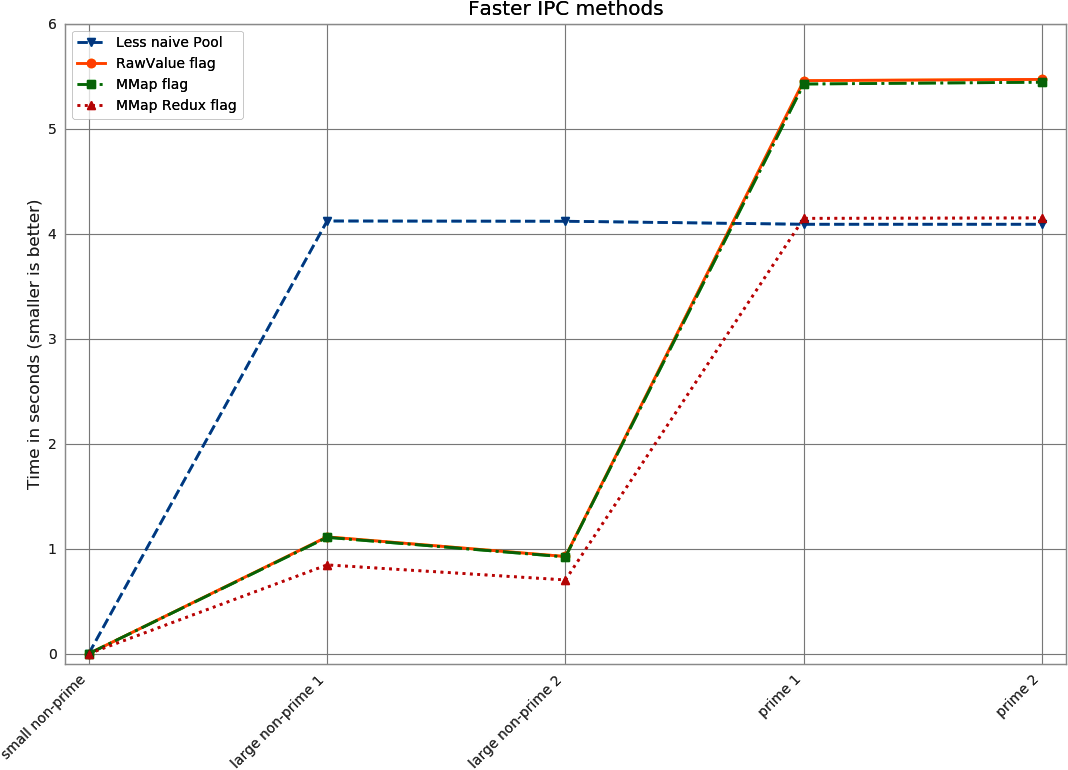

用IPC验证素性的快速方法。

## 串行解决方案

串行验证

## 原始池解决方案

naivepool解决方案使用multiprocessing.Pool，类似于我们在“查找素数”和“使用进程和线程估计Pi”中看到的四个分叉进程。我们有一个数字来测试素数，我们把可能的因子范围分成四个元组的子范围，然后把它们发送到池中。

在示例中，我们使用了一种新的方法，create_range.create（我们不会说它很无聊），它将工作空间分割成大小相等的区域。ranges_to_check 中的每一项都是一对要在其中搜索的上下限。对于前18位非质数(100,109,100,129,100,369)，通过四个过程，我们将使因子范围ranges_to_check == [(3, 79_100_057), (79_100_057, 158_200_111), (158_200_111, 237_300_165), (237_300_165, 316_400_222)]（其中316400222是100109100129100369加1的平方根）。在__main__ 中，我们首先建立一个池；check_prime然后通过映射为每个可能的素数n拆分ranges_to_check。如果结果是False，我们找到了一个因子，我们没有素数。

原始池解决方案：

我们在示例中修改了前面的 check_prime 为检查范围取上下限。传递一个完整的可能要检查的因素列表是没有价值的，所以我们只传递定义范围的两个数字，这样可以节省时间和内存。

对于“小无质”的情况，通过池的验证时间是0.1秒，比串行解决方案中原来的0.000002秒要长得多。尽管这是一个更糟糕的结果，但总体结果是全面提速。我们也许可以接受一个较慢的结果不是问题，但如果我们可以得到许多较小的非Prime来检查呢？事实证明，我们可以避免这种放缓；接下来我们将使用不那么简单的池解决方案来了解这一点。

## 一个不那么幼稚的池解决方案

以前的解决方案在验证较小的非抵押贷款时效率很低。对于任何更小（少于18位）的非质数，它可能比串行方法慢，因为发送分区工作的开销以及不知道是否会找到非常小的因子（这是一个更可能的因子）。如果找到一个较小的因子，该过程仍需等待其他较大因子搜索完成。

我们可以开始在进程之间发出信号，表明找到了一个小因素，但由于这种情况如此频繁地发生，这将增加大量的通信开销。示例中给出的解决方案 9-17是一种更实用的方法——对可能的小因素快速执行串行检查，如果没有发现，则开始并行搜索。在启动一个相对昂贵的并行操作之前结合一个串行预检查是一种避免并行计算成本的常用方法。

小非素数朴素池解决方案的改进：

这个解决方案的速度等于或优于原始的串行搜索我们的每个测试号码。这是我们的新基准。

重要的是，这个池方法为我们提供了一个最佳的基本检查情况。如果我们有黄金期，就没有办法提前退出；我们必须手动检查所有可能的因素才能退出。

没有更快的方法来检查这些因素：任何增加复杂性的方法都会有更多的指令，因此检查所有因素的情况将导致执行最多的指令。有关如何尽可能接近当前质数结果的讨论，请参阅“使用mmap作为标志”中介绍的各种mmap解决方案。

## 使用Manager.Value作为标志

将Manager.Value对象作为标志传递：

check_prime_in_range 现在将知道共享标志，例程将检查是否有其他进程发现了一个prime。尽管我们还没有开始并行搜索，但我们必须清除该标志，如示例所示 在我们开始序列检查之前。在完成了序列检查之后，如果我们还没有找到一个因子，我们就知道这个标志肯定还是假的。

用Manager.Value清除标志：

我们应该多久检查一次共享标志？每次检查都要付出代价，这既是因为我们要向紧凑的内部循环添加更多的指令，也是因为检查需要对共享变量进行锁定，这会增加更多的代价。我们选择的解决方案是每一千次迭代检查一次标志。每次检查时，我们都会查看value.value是否已设置为 FLAG_SET，如果已设置，则退出搜索。如果在搜索过程中找到一个因子，则设置 value.value = FLAG_SET 并退出

将Manager.Value对象作为标志传递：

## 使用Redis作为标志

为了确认数据存储在这些Python实例之外，我们可以在命令行调用 redis-cli，如下面的示例所示，并获取存储在 redis_primes_flag 中的值。您将注意到返回的项是一个字符串（不是整数）。Redis返回的所有值都是字符串，因此如果您想在Python中操作它们，必须首先将它们转换为适当的数据类型。

例redis客户端

Redis应用广泛，成熟可靠。如果您不熟悉该工具，我们强烈建议您查看一下；它在您的高性能工具箱中占有一席之地。

## 使用RawValue作为标志

使用托管值和原始值的灵活性是多处理中数据共享的干净设计的一个好处。

## 使用mmap作为标志

最后，我们得到了共享字节的最快方式。例子 9-24显示了使用mmap模块的内存映射（共享内存）解决方案。共享内存块中的字节不同步，而且开销很小。它们的行为就像一个文件，在这种情况下，它们是一个内存块，具有类似文件的接口。我们必须寻找一个位置并按顺序读写。通常，mmap用于将一个短（内存映射）视图提供给一个更大的文件，但是在我们的示例中，不是指定一个文件号作为第一个参数，而是传递-1来表示我们需要一个匿名内存块。我们还可以指定是要只读访问还是只写访问（我们都要，这是默认值）。

例9-24。通过mmap使用共享内存标志

mmap支持许多方法，可以用来在它所表示的文件中移动（包括find、readline和write）。我们以最基本的方式使用它，在每次读或写之前寻找内存块的开始，因为我们只共享一个字节，所以我们使用 read_byte 和 write_byte 来显式地表示。

没有用于锁定的Python开销，也没有对数据的解释；我们直接与操作系统处理字节，所以这是我们最快的通信方法。

## 使用mmap作为Redux标志

虽然前面的mmap结果总体上是最好的，但我们还是忍不住认为，对于最昂贵的素数情况，我们应该能够回到原始池结果。我们的目标是接受内部循环没有提前退出的事实，并尽可能降低任何无关的成本。

本节提供了一个稍微复杂一点的解决方案。我们看到的其他基于标志的方法也可以做同样的更改，尽管这个mmap结果仍然是最快的。

在前面的示例中，我们使用了CHECK_EVERY 。这意味着我们有 check_next 局部变量来跟踪、递减，并在布尔测试中使用，并且每个操作都会为每次迭代增加一点额外的时间。在验证一个大素数的情况下，这个额外的管理开销发生了超过300000次。

第一个优化，如示例所示 9-25，就是要认识到我们可以用一个先行值替换递减的计数器，然后我们只需要在内部循环上做一个布尔比较。这就消除了减量，由于Python的解释风格，减量相当慢。这种优化在cpython3.7的测试中有效，但在更智能的编译器（例如PyPy或Cython）中不太可能提供任何好处。这一步节省了0.1秒，当检查我们的一个大素数。

例9-25。开始优化我们昂贵的逻辑

我们还可以完全替换计数器表示的逻辑，如示例所示 9-26，将循环展开为两个阶段。首先，外循环覆盖了预期的范围，但是在 CHECK_EVERY 上是逐步的。第二，一个新的内部循环替换了check\u，它 check_every 逻辑的局部因子范围，然后完成。这相当于if not check_every:测试。我们按照前面的 sh_mem 逻辑检查early exit标志。

优化我们昂贵的逻辑：

提示
这些示例在PyPy中运行得很好，它们的运行速度是CPython的7倍。有时，更好的解决方案是研究其他运行时，而不是用CPython去钻兔子洞。